<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter09/Class_Rectification_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sm
from collections import Counter

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

# load data
test_seq = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomAffine(10, shear=10)] + test_seq
)
train_dataset = torchvision.datasets.MNIST(
    ".", train=True, download=True, transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(".", train=False, transform=test_transform),
    batch_size=500,
)

Distribution of classes in Imbalanced dataset:
Counter({0: 5923, 1: 3596, 2: 2156, 3: 1292, 4: 774, 5: 464, 6: 278, 7: 166, 8: 100, 9: 60})


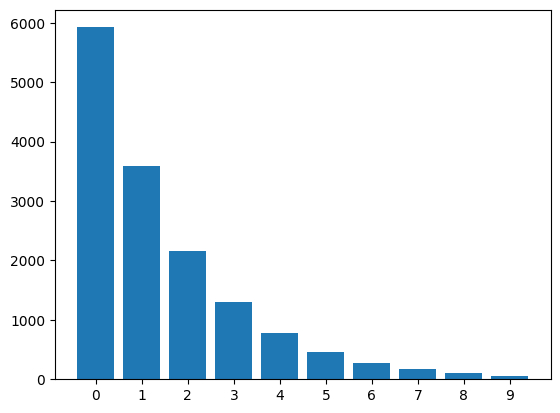

In [3]:
trainset = torchvision.datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1302,), (0.3069,)),
        ]
    ),
)


# generate imbalanced dataset
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)
idx_to_remove = []


def get_img_num_per_cls(data, num_classes=10, imb_type="exp", imb_factor=0.01):
    img_max = len(data) / num_classes
    img_num_per_cls = []
    if imb_type == "exp":
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor ** (cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    return img_num_per_cls


def gen_imbalanced_data(targets, img_num_per_cls):
    targets_np = np.array(targets, dtype=np.int64)
    classes = np.unique(targets_np)
    num_per_cls_dict = dict()
    idx_to_remove = []
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        np.random.shuffle(idx)
        selec_idx = idx[:the_img_num]
        idx_to_remove.extend(list(np.setdiff1d(idx, selec_idx)))
    return idx_to_remove


img_num_per_cls = get_img_num_per_cls(trainset)
idx_to_remove = gen_imbalanced_data(trainset.targets, img_num_per_cls)

# print('idx_to_remove: ', idx_to_remove)
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)
print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64, shuffle=True
)

Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


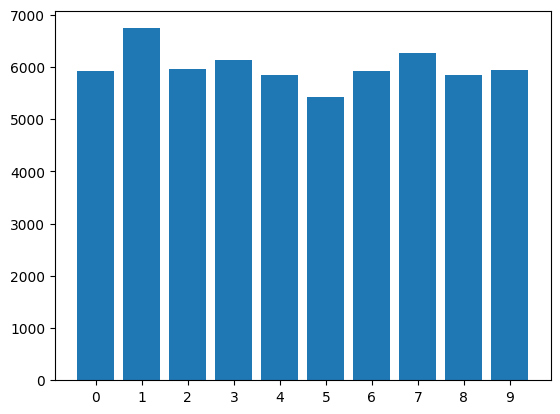

Sampling probability for each class:


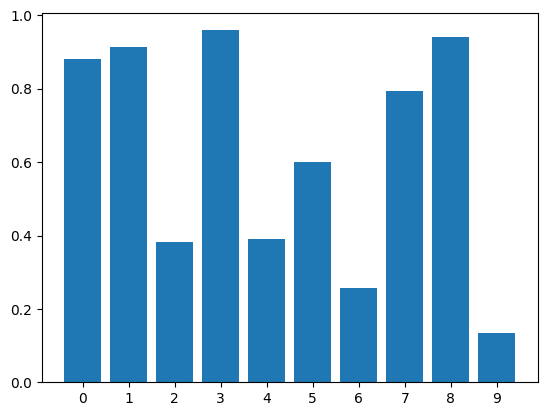

Imbalanced dataset: 14809 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


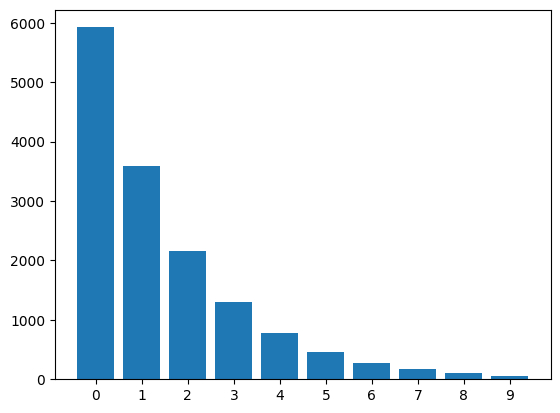

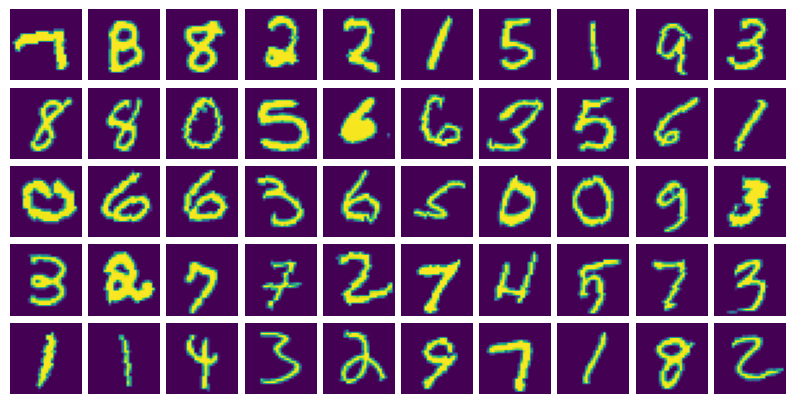

In [4]:
def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)

    f, a = plt.subplots(nrow, ncol, figsize=figsize)

    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis("off")

    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()


def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%" % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"

    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, "g")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", annot_kws={"size": 10})
    plt.show()
    return annot


print(
    "Original dataset: %d training samples & %d testing samples\n"
    % (len(train_loader.dataset), len(test_loader.dataset))
)

print("Distribution of classes in original dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

print("Sampling probability for each class:")
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

print(
    "Imbalanced dataset: %d training samples & %d testing samples\n"
    % (len(imbalanced_train_loader.dataset), len(test_loader.dataset))
)

print("Distribution of classes in imbalanced dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
def process(train_loader, test_loader, lossCriterion, epochs=60, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    if lossCriterion == torch.nn.NLLLoss:
        print("loss is CrossEntropyLoss")
        criterion = lossCriterion()
    else:
        print(sorted(dict(Counter(train_loader.dataset.targets.numpy())).items()))
        num_class_list = []
        for item in sorted(dict(Counter(train_loader.dataset.targets.numpy())).items()):
            num_class_list.append(item[1])

        print("num_class_list", num_class_list)
        criterion = lossCriterion(np.array(num_class_list), 10)

    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[
                    1
                ]  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100.0 * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    test_accs, confusion_mtxes = [], []
    for epoch in range(0, epochs):
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print("\rBest test acc = %2.2f%%" % max(test_accs))

    confusion_mtx = vis(test_accs, confusion_mtxes, classe_labels)
    return test_accs[np.argmax(test_accs)], confusion_mtx

# Baseline using Cross Entropy Loss

loss is CrossEntropyLoss
Best test acc = 46.11%
Best test acc = 60.40%
Best test acc = 65.21%
Best test acc = 68.46%
Best test acc = 70.80%
Best test acc = 72.06%
Best test acc = 73.38%
Best test acc = 74.86%
Best test acc = 77.50%
Best test acc = 77.50%
Best test acc = 77.81%
Best test acc = 79.50%
Best test acc = 79.50%
Best test acc = 81.48%
Best test acc = 81.48%
Best test acc = 81.48%
Best test acc = 82.12%
Best test acc = 84.55%
Best test acc = 84.55%
Best test acc = 84.55%
Best test acc = 84.55%
Best test acc = 84.55%
Best test acc = 84.55%
Best test acc = 84.55%
Best test acc = 84.70%
Best test acc = 85.39%
Best test acc = 85.46%
Best test acc = 86.39%
Best test acc = 86.39%
Best test acc = 86.39%
Best test acc = 87.11%
Best test acc = 87.11%
Best test acc = 87.11%
Best test acc = 87.88%
Best test acc = 87.88%
Best test acc = 87.88%
Best test acc = 87.88%
Best test acc = 87.88%
Best test acc = 87.88%
Best test acc = 87.95%
Best test acc = 87.95%
Best test acc = 87.95%
Best test

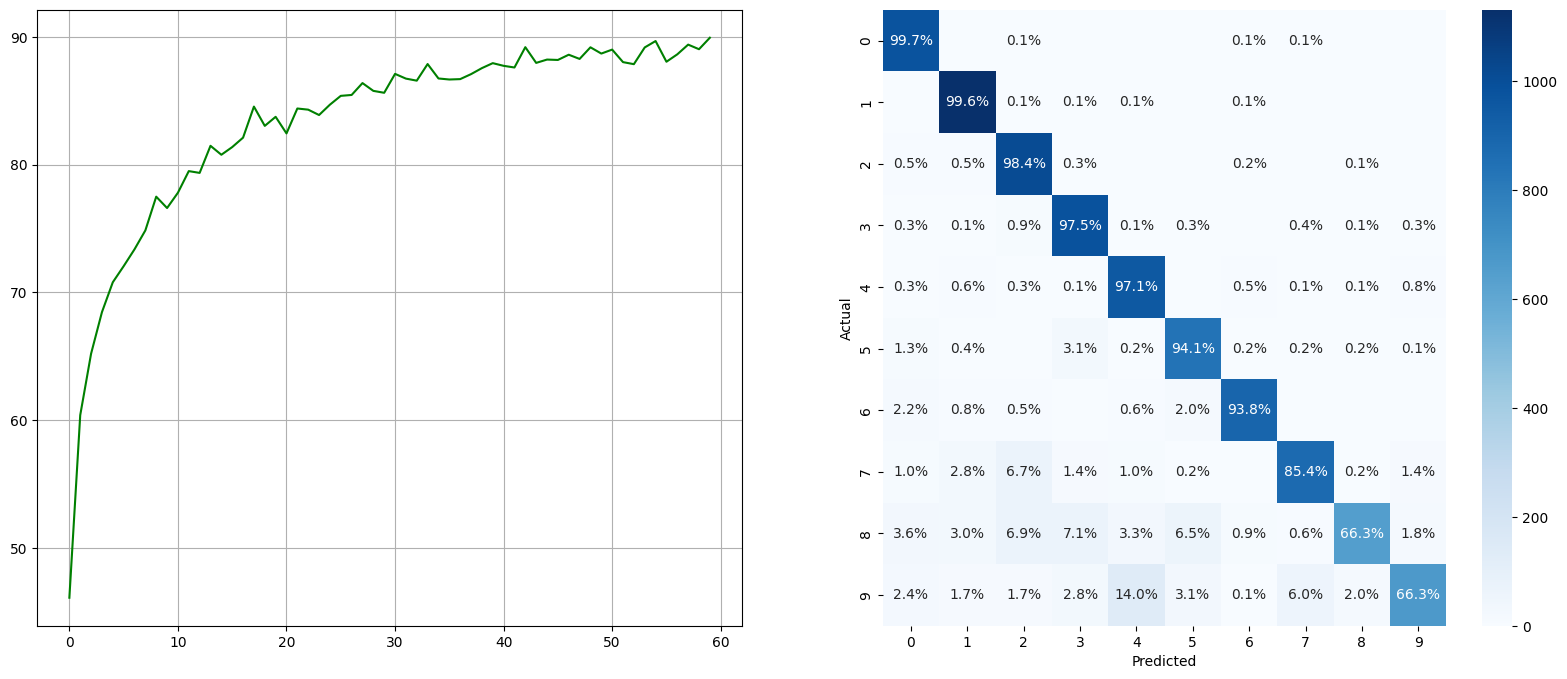

In [7]:
# baseline of torch.nn.CrossEntropyLoss
test_acc_crossentropy, confusion_mtx_crossentropy = process(
    imbalanced_train_loader, test_loader, torch.nn.NLLLoss
)

In [8]:
class ClassLevelHardMining:
    def __init__(self, labels):
        super(ClassLevelHardMining, self).__init__()
        self.sample_counts = Counter(labels.tolist())
        self.omega = None  # Class imbalance measure
        self.minority_class = None
        self.minority_indices = None
        self.majority_class = None
        self.majority_indices = None

    def _make_omega(self, majority_class_label, minority_class_label):
        if self.omega is not None:
            return self.omega
        return (
            self.sample_counts[majority_class_label]
            - self.sample_counts[minority_class_label]
        ) / (self.sample_counts[majority_class_label] + 0.05)

    def on_batch_begin(self, last_target):
        targets = last_target.cpu()
        target_indices = set(enumerate(targets))
        label_count = Counter(targets.tolist())
        self.minority_class = min(
            label_count, key=label_count.get
        )  # Find the class with the least num of samples
        self.minority_indices = [
            i[0] for i in target_indices if i[1] == self.minority_class
        ]
        self.majority_class = max(label_count, key=label_count.get)
        self.majority_indices = [
            i[0] for i in target_indices if i[1] == self.majority_class
        ]
        self.omega = self._make_omega(self.majority_class, self.minority_class)

    def on_loss_begin(self, last_output):
        predictions = last_output.cpu()
        # Every minority sample is also treated as an anchor
        minority_predictions = anchors = torch.exp(predictions[self.minority_indices][
            :, self.minority_class
        ])
        majority_predictions = torch.exp(predictions[self.majority_indices][
            :, self.majority_class
        ])
        # print(minority_predictions)
        k = len(minority_predictions) if len(minority_predictions) < 25 else 25

        # take lowest k prediction scores for minority class: hard positive samples
        bottom_k_hard_pos = torch.sort(minority_predictions)[0][:k]

        # take highest k prediction scores from the opposite class(viz majority class): hard negative samples
        top_k_hard_neg = torch.sort(majority_predictions, descending=True)[0][:k]
        return (anchors, bottom_k_hard_pos, top_k_hard_neg, predictions, self.omega)

##### Let's write our custom loss function named `ClassRectificationLoss`

In [9]:
class ClassRectificationLoss(nn.Module):
    def __init__(self, eta=0.01, margin=0.25):
        super(ClassRectificationLoss, self).__init__()
        self.eta = eta  # Subparameter of α
        self.margin = margin

    def _relative_comparison(self, anchor, positive, negative):
        distance_positive = F.l1_loss(anchor, positive, reduction="mean")
        distance_negative = F.l1_loss(anchor, negative, reduction="mean")
        losses = F.relu(
            distance_positive - distance_negative + self.margin
        )  # Triplet Loss
        return losses.mean()

    def forward(self, last_output, targets, reduction="none"):
        targets = targets.cpu()
        a, p, n, predictions, omega = last_output
        alpha = self.eta * omega
        return (alpha * self._relative_comparison(a, p, n)) + (
            (1 - alpha) * F.nll_loss(predictions, targets)
        )

# Class Rectification Loss

##### Let's initialize the model and implement the training loop utilizing our new loss function of ClassRectificationLoss and ClassLevelHardMining as a callback function.

In [10]:
def process_hardmining(
    train_loader,
    test_loader,
    ClassRectificationLoss,
    ClassLevelHardMining,
    epochs=60,
    weight=None,
):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    rectificationloss = ClassRectificationLoss().to(device)

    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            classhardmining = ClassLevelHardMining(target)
            classhardmining.on_batch_begin(target)
            output = model(data)
            triplet_output = classhardmining.on_loss_begin(output)
            loss = rectificationloss(triplet_output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[
                    1
                ]  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100.0 * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    test_accs, confusion_mtxes = [], []
    for epoch in range(0, epochs):
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print("\rBest test acc = %2.2f%%" % max(test_accs))

    confusion_mtx = vis(test_accs, confusion_mtxes, classe_labels)
    return test_accs[np.argmax(test_accs)], confusion_mtx

Best test acc = 47.63%
Best test acc = 56.80%
Best test acc = 64.41%
Best test acc = 67.92%
Best test acc = 69.68%
Best test acc = 73.15%
Best test acc = 73.15%
Best test acc = 75.04%
Best test acc = 76.24%
Best test acc = 77.40%
Best test acc = 77.74%
Best test acc = 79.47%
Best test acc = 79.87%
Best test acc = 80.05%
Best test acc = 81.39%
Best test acc = 82.12%
Best test acc = 82.12%
Best test acc = 82.72%
Best test acc = 82.72%
Best test acc = 83.02%
Best test acc = 84.37%
Best test acc = 84.37%
Best test acc = 84.37%
Best test acc = 84.37%
Best test acc = 84.88%
Best test acc = 84.88%
Best test acc = 84.95%
Best test acc = 85.86%
Best test acc = 85.86%
Best test acc = 85.86%
Best test acc = 85.86%
Best test acc = 86.08%
Best test acc = 86.78%
Best test acc = 86.78%
Best test acc = 87.02%
Best test acc = 87.31%
Best test acc = 88.42%
Best test acc = 88.42%
Best test acc = 88.42%
Best test acc = 88.42%
Best test acc = 88.42%
Best test acc = 88.42%
Best test acc = 88.42%
Best test a

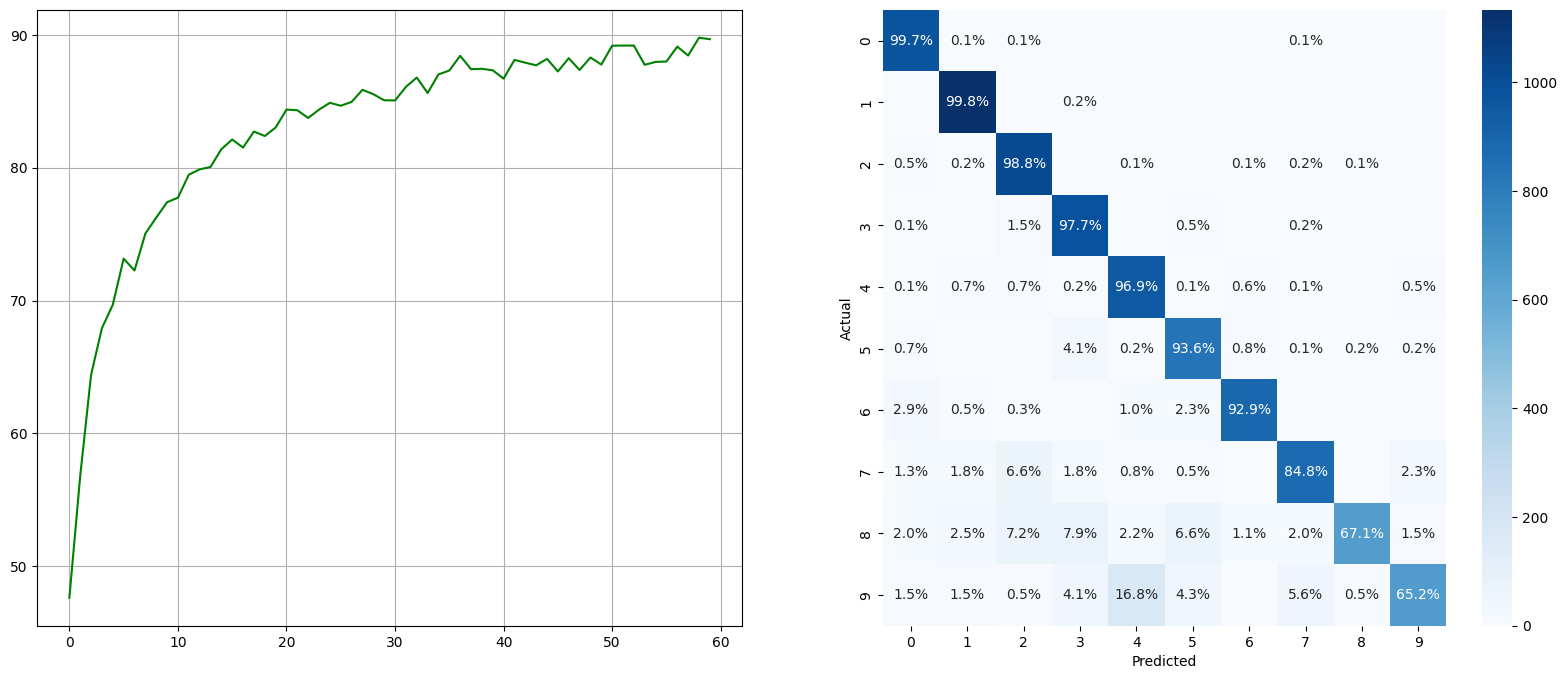

In [11]:
test_acc_hardmining, confusion_mtx_hardmining = process_hardmining(
    imbalanced_train_loader, test_loader, ClassRectificationLoss, ClassLevelHardMining
)

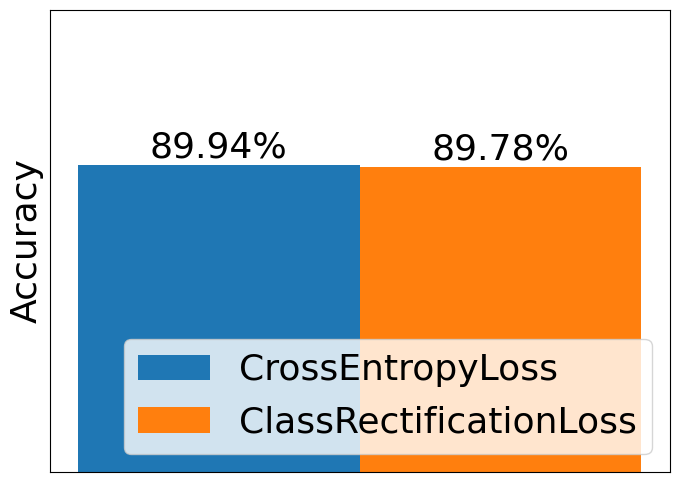

In [12]:
fig = plt.subplots(figsize=(8, 6))
plt.rcParams["font.size"] = 26

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(
    br1,
    np.array(test_acc_crossentropy).astype(float),
    width=0.1,
    label="CrossEntropyLoss",
)
p2 = plt.bar(
    br2,
    np.array(test_acc_hardmining).astype(float),
    width=0.1,
    label="ClassRectificationLoss",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )

plt.ylim(70, 100)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.legend(loc="lower right")
plt.ylabel("Accuracy", fontsize=26)
plt.show()

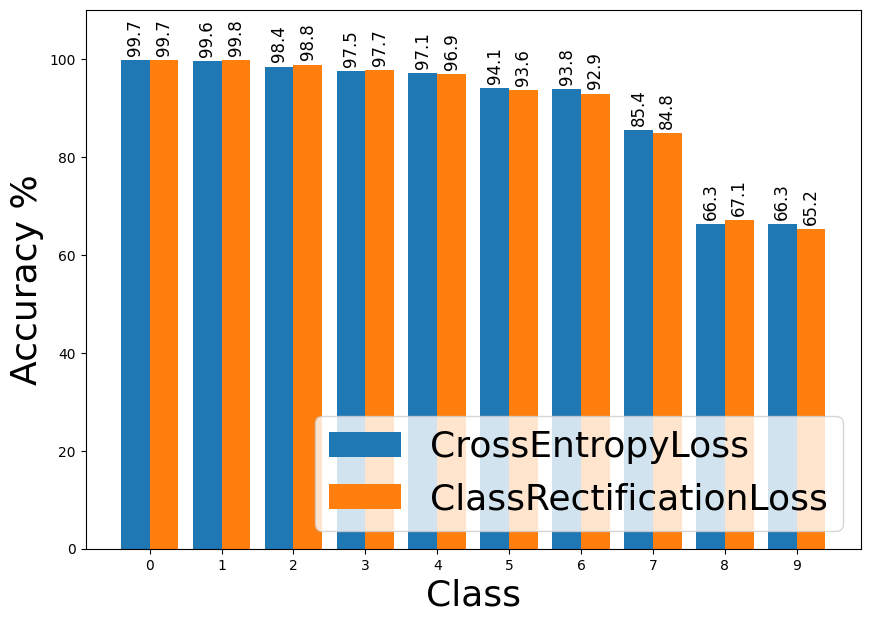

In [13]:
fig = plt.subplots(figsize=(10, 7))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
class_percentages_crossentropy = [
    confusion_mtx_crossentropy[i][i][:-1] for i in range(10)
]
class_percentages2_hardmining = [confusion_mtx_hardmining[i][i][:-1] for i in range(10)]


p1 = plt.bar(
    br1,
    np.array(class_percentages_crossentropy).astype(float),
    width=0.4,
    label="CrossEntropyLoss",
)
p2 = plt.bar(
    br2,
    np.array(class_percentages2_hardmining).astype(float),
    width=0.4,
    label="ClassRectificationLoss",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.1f}".format((height)),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.9),
        ha="center",
        va="bottom",
        fontsize=12,
        rotation="vertical",
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.1f}".format((height)),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.9),
        ha="center",
        va="bottom",
        fontsize=12,
        rotation="vertical",
    )

plt.xticks(
    [r + 0.2 for r in range(10)], ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
)
plt.ylim(0, 110)
plt.legend(loc="lower right")
plt.xlabel("Class", fontsize=26)
plt.ylabel("Accuracy %", fontsize=26)
plt.rc("xtick", labelsize=26)
plt.rc("ytick", labelsize=26)
plt.show()